In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.optimize import curve_fit, minimize
from scipy.signal import find_peaks, peak_widths
from scipy import sparse
from scipy.sparse.linalg import spsolve
sys.path.append('scripts')
from raman_plot import Spectrum
from peak_fitting import *
from sorted_for_stats import hmds, gl, boot, gs
from statistics import mean, stdev, median

In [2]:
def remove_base_1(sample, p=0.001, lam=100000000):
    z = baseline_als(sample.Intensity1, lam, p)
    return sample.Intensity1 - z
    #plt.plot(sample.Wavenumber1, sample.Intensity1, sample.Wavenumber1, z)

def remove_base_2(sample, p=0.001, lam=100000000):
    z = baseline_als(sample.Intensity2, lam, p)
    return sample.Intensity2 - z
    
def fit_D_peak(x,y):
    guess = [1350, 10000, 20]
    low, high = 1300, 1400
    x_new = x[x > low][x < high]
    y_new = y.iloc[x_new.index[0]:x_new.index[-1]+1]
    popt, pcov = curve_fit(func(1), x_new, y_new, guess, maxfev=10000, bounds=(0, 200000))
    return popt

def fit_G_Dprime_peak(x,y):
    guess = [1590, 10000, 20, 1630, 10000, 20]
    bounds = ([1580, 100, 1, 1610, 100, 1], [1600, 200000, 100, 1630, 200000, 100])
    low, high = 1540, 1650
    x_new = x[x > low][x < high]
    y_new = y.iloc[x_new.index[0]:x_new.index[-1]+1]
    popt, pcov = curve_fit(func(2), x_new, y_new, guess, maxfev=10000, bounds=bounds)
    peak1, peak2 = popt[:3], popt[3:]
    return peak1, peak2

def fit_2D_peaks(x,y): #This function is to fit 2 peaks inside an asymmetric peak
    guess = [2700, 10000, 20, 2700, 10000, 20]
    bounds = ([2600, 100, 1, 2600, 100, 1],
              [2800, 200000, 100, 2800, 200000, 100])
    low, high = 2600, 2800
    x_new = x[x > low][x < high]
    y_new = y.iloc[x_new.index[0]:x_new.index[-1]+1]
    popt, pcov = curve_fit(func(2), x_new, y_new, guess, maxfev=10000, bounds=bounds)
    peak1, peak2 = popt[:3], popt[3:]
    return peak1, peak2

def fit_2D_peak(x,y):
    guess = [2700, 10000, 20]
    low, high = 2600, 2800
    x_new = x[x > low][x < high]
    y_new = y.iloc[x_new.index[0]:x_new.index[-1]+1]
    popt, pcov = curve_fit(func(1), x_new, y_new, guess, maxfev=10000, bounds=(0, 200000))
    return popt

# Part 1: Looking at D' peak in hmds

In [3]:
def get_sample_peaks(sample):
    ts = sample["spectra"].keys()
    sample["peaks"] = dict()
    for t in ts:
        sample_at_t = sample['spectra'][t]
        sample["peaks"][t] = dict()
        for i in range(len(sample_at_t)):
            spectrum = sample_at_t[i]
            # Remove the baseline
            x = spectrum.Wavenumber1
            new_y = remove_base_1(spectrum)
            # Find D peak
            d_peak = fit_D_peak(x, new_y)
            # Find G and D' peaks
            g_peak, dprime_peak = fit_G_Dprime_peak(x, new_y)
            sample['peaks'][t][i] = {"d_peak":d_peak, "g_peak":g_peak, "dprime_peak":dprime_peak}

get_sample_peaks(hmds)
get_sample_peaks(boot)

Text(0.5, 0, 'Last temperature of annealing (°C)')

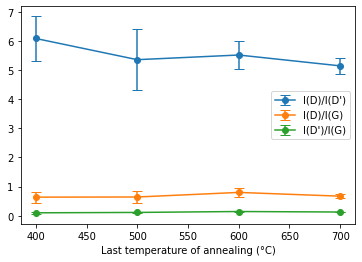

In [4]:
#sample to plot
sample = hmds
ts = sample["spectra"].keys()
d_gs = []
d_dprimes = []
dprime_gs = []
d_gs_error = []
d_dprimes_error = []
dprime_gs_error = []
for t in ts:
    d_peaks = [sample["peaks"][t][i]['d_peak'][1] for i in range(len(sample["peaks"][t]))]
    g_peaks = [sample["peaks"][t][i]['g_peak'][1] for i in range(len(sample["peaks"][t]))]
    dprime_peaks = [sample["peaks"][t][i]['dprime_peak'][1] for i in range(len(sample["peaks"][t]))]
    d_dprime = [d1/d2 for d1,d2 in zip(d_peaks, dprime_peaks)]
    d_g = [d1/d2 for d1,d2 in zip(d_peaks, g_peaks)]
    dprime_g = [d1/d2 for d1,d2 in zip(dprime_peaks, g_peaks)]
    d_dprimes.append(median(d_dprime))
    d_gs.append(median(d_g))
    dprime_gs.append(median(dprime_g))
    d_dprimes_error.append(stdev(d_dprime))
    d_gs_error.append(stdev(d_g))
    dprime_gs_error.append(stdev(dprime_g))
    
plt.errorbar(ts, d_dprimes, d_dprimes_error, fmt="-o", label="I(D)/I(D')", capsize=5)
plt.errorbar(ts, d_gs, d_gs_error, fmt="-o", label="I(D)/I(G)", capsize=5)
plt.errorbar(ts, dprime_gs, dprime_gs_error, fmt="-o", label="I(D')/I(G)", capsize=5)
plt.legend()
plt.xlabel("Last temperature of annealing (°C)")
#plt.ylim([0, 2])

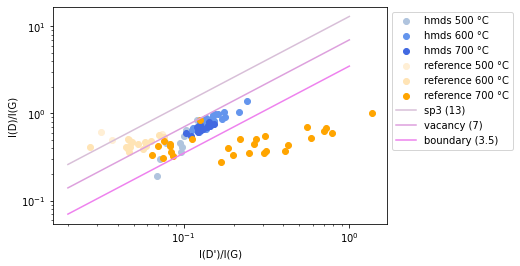

In [5]:
#I(D)/I(G) vs #I(D')/I(G)
ts = boot["spectra"].keys()
for sample in [hmds, boot]:
    if sample["name"] == "hmds":
        colors = ["lightsteelblue", "cornflowerblue","royalblue"]
    else:
        colors = ["papayawhip", "moccasin", "orange"]
    for i, t in enumerate(ts):
        d_peaks = [sample["peaks"][t][i]['d_peak'][1] for i in range(len(sample["peaks"][t]))]
        g_peaks = [sample["peaks"][t][i]['g_peak'][1] for i in range(len(sample["peaks"][t]))]
        dprime_peaks = [sample["peaks"][t][i]['dprime_peak'][1] for i in range(len(sample["peaks"][t]))]
        d_dprime = [d1/d2 for d1,d2 in zip(d_peaks, dprime_peaks)]
        d_g = [d1/d2 for d1,d2 in zip(d_peaks, g_peaks)]
        dprime_g = [d1/d2 for d1,d2 in zip(dprime_peaks, g_peaks)]
        plt.scatter(dprime_g, d_g, color=colors[i], label=f"{sample['name']} {t} °C")
x = np.linspace(0.02, 1, 30)
plt.plot(x, 13*x, color="thistle", label="sp3 (13)")
plt.plot(x, 7*x, color="plum", label="vacancy (7)")
plt.plot(x, 3.5*x, color="violet", label="boundary (3.5)")
plt.ylabel("I(D)/I(G)")
plt.xlabel("I(D')/I(G)")
plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1, 1))

# Part 2: Looking at splitting of 2d peak in gold sample

In [ ]:
sample = gs
sample["peaks"] = dict()
for t in [500, 600, 700]:
    sample_at_t = sample['spectra'][t]
    sample["peaks"][t] = dict()
    for i in range(len(sample_at_t)):
        spectrum = sample_at_t[i]
        # Remove the baseline
        x1, x2 = spectrum.Wavenumber1, spectrum.Wavenumber2
        new_y_1, new_y_2 = remove_base_1(spectrum), remove_base_2(spectrum)
        # Find D peak
        d_peak = fit_D_peak(x1, new_y_1)
        # Find G and D' peaks
        g_peak, dprime_peak = fit_G_Dprime_peak(x1, new_y_1)
        # Find 2D peak
        d2_peak = fit_2D_peak(x2, new_y_2)
        # Find 2D peaks
        d2_peak1, d2_peak2 = fit_2D_peaks(x2, new_y_2)
        sample['peaks'][t][i] = {"d_peak":d_peak, "g_peak":g_peak, "dprime_peak":dprime_peak, 
                                 "2d_peak":d2_peak, "2d_peak1":d2_peak1, "2d_peak2":d2_peak2}

In [ ]:
strain_shift = np.poly1d([2.1866773,-782.30125634])
p_doping_shift = np.poly1d([6.96659036e-01,1.57483421e+03])
X = np.linspace(1580, 1597, 100)
plt.plot(X, strain_shift(X), 'k--', label="strain (Lee, J.E. et al)")
plt.plot(X, p_doping_shift(X), 'r--', label="p-doping (Lee, J.E. et al)")
for t in [500, 600, 700]:
    d_peaks = [sample["peaks"][t][i]['d_peak'][0] for i in range(len(sample["peaks"][t]))]
    g_peaks = [sample["peaks"][t][i]['g_peak'][0] for i in range(len(sample["peaks"][t]))]
    d2_peaks = [sample["peaks"][t][i]['2d_peak'][0] for i in range(len(sample["peaks"][t]))]
    plt.scatter(g_peaks, d2_peaks, label=f"{t} °C")
plt.legend()
plt.ylabel(r'2D peak position (cm$^{-1}$)')
plt.xlabel(r'G peak position (cm$^{-1}$)')

# Extras

Plots of the Lorentzian peak to check functions

In [ ]:
def fit_d_peak_view(x, y):
    guess = [1340, 10000, 20]
    low, high = 1300, 1400
    n = 1
    x_new = x[x > low][x < high]
    y_new = y.iloc[x_new.index[0]:x_new.index[-1]+1]
    popt, pcov = curve_fit(func(n), x_new, y_new, guess, maxfev=10000, bounds=(0, 200000))
    print(popt)

    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(211)
    ax.plot(x, y)
    ax.plot(x,func(n)(x,*popt))

    for i in range(1,n+1):
        peak = popt[3*i-3:3*i]
        print(peak)
        ax.plot(x,lorentzian(x,*peak))
        
def fit_g_peak_view(x, y):
    guess = [1590, 10000, 20, 1630, 10000, 20]
    bounds = ([1580, 100, 1, 1610, 100, 1], [1600, 200000, 100, 1630, 200000, 100])
    low, high = 1540, 1650
    n = 2
    x_new = x[x > low][x < high]
    y_new = y.iloc[x_new.index[0]:x_new.index[-1]+1]
    popt, pcov = curve_fit(func(n), x_new, y_new, guess, maxfev=10000, bounds=bounds)
    print(popt)

    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(211)
    ax.plot(x, y)
    ax.plot(x,func(n)(x,*popt))

    for i in range(1,n+1):
        peak = popt[3*i-3:3*i]
        print(peak)
        ax.plot(x,lorentzian(x,*peak))

def fit_2d_peak_view(x, y):
    guess = [2700, 10000, 20, 2700, 10000, 20]
    bounds = ([2600, 100, 1, 2600, 100, 1],
              [2800, 200000, 100, 2800, 200000, 100])
    low, high = 2600, 2800
    n = 2
    x_new = x[x > low][x < high]
    y_new = y.iloc[x_new.index[0]:x_new.index[-1]+1]
    popt, pcov = curve_fit(func(n), x_new, y_new, guess, maxfev=10000, bounds=bounds)
    print(popt)

    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(211)
    ax.plot(x, y)
    ax.plot(x,func(n)(x,*popt))

    for i in range(1,n+1):
        peak = popt[3*i-3:3*i]
        print(peak)
        ax.plot(x,lorentzian(x,*peak))

In [ ]:
sample = gl['spectra'][500][2]#[350:500]
new_y = remove_base_2(sample)
fit_2d_peak_view(sample.Wavenumber2, new_y)

In [ ]:
sample = gl['spectra'][500][2]#[350:500]
new_y = remove_base_1(sample)
fit_g_peak_view(sample.Wavenumber1, new_y)

In [ ]:
sample = gl['spectra'][500][10]
new_y = remove_base_2(sample)
plt.plot(sample.Wavenumber2, new_y)
peaks = fit_2d_peak_view(gl['spectra'][700][1].Wavenumber2, new_y)
#plt.xlim([2600, 2800])